In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH  = os.path.join('data','images')
number_images  = 10

In [14]:
# As of now, captured img from phone as there seems some issues with opencv and windows
# below code opens camera and saves images captured in data/image folder
# cap = cv2.VideoCapture(1)
# if cap.isOpened():
#     for imgnum in range(number_images):
#         print("Collecting image {}".format(imgnum))
#         ret, frame = cap.read()
#         imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#         cv2.imwrite(imgname,frame)
#         cv2.imshow('frame',frame)
#         time.sleep(5)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#         cap.release()
#         cv2.destroyAllWindows()


In [3]:
!labelme

2024-08-15 18:23:14,766 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\ugupt\.labelmerc


<h2>Review Dataset and Build image Loading Function</h2>

In [4]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# test gpu
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

tf.test.is_gpu_available()

False

In [1]:
#images = tf.data.Dataset.list_files('data\\images\\*jpg',shuffle=True)

In [22]:
images.as_numpy_iterator().next()

b'data\\images\\IMG_20240612_202734.jpg'

In [6]:
def load_image(x):
    byte_img  = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_img)
    return image

In [24]:
images = images.map(load_image)

In [25]:
images.as_numpy_iterator().next()

array([[[216, 194, 171],
        [215, 193, 170],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [205, 199, 185],
        [205, 199, 185]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [206, 200, 186],
        [206, 200, 186]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [207, 201, 187],
        [206, 200, 186],
        [207, 201, 187]],

       ...,

       [[ 72,  70,  55],
        [ 72,  70,  55],
        [ 76,  74,  59],
        ...,
        [210, 210, 200],
        [210, 210, 200],
        [210, 210, 200]],

       [[ 75,  73,  58],
        [ 76,  74,  59],
        [ 77,  75,  60],
        ...,
        [210, 210, 200],
        [208, 208, 198],
        [208, 208, 198]],

       [[ 77,  75,  60],
        [ 78,  76,  61],
        [ 78,  76,  61],
        ...,
        [210, 210, 200],
        [207, 207, 197],
        [207, 207, 197]]

<h4>View raw images with matplotlib</h4>

In [26]:
image_generator = images.batch(4).as_numpy_iterator()

In [27]:
plot_images = image_generator.next()

In [6]:
# fig, ax = plt.subplots(ncols=4,figsize=(20,30))
# for idx,image in enumerate(plot_images):
#     pass
# #     ax[idx].imshow(image)
# # plt.show()

<h2>3. Partition Unaugmented Data</h2>

In [31]:
# manual partition
# 60-> train, 15 ->test, 15-> val


<h4>Move the Matching Labels</h4>
<h6>Due to this the labels gets moved to respective 3 folders created</h6>

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

<h2>4. Apply Image Augmentation on Images and Labels using Albumentations</h2>

<h4>4.A Setup Albumentations Transform Pipeline</h4>

In [13]:
import albumentations as alb

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [14]:
augmentor = alb.Compose([alb.RandomCrop(width=2000, height=2000), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

<h4>4.B Load a Test Image and Annotation with OpenCV and JSON</h4>

In [15]:
img = cv2.imread(os.path.join('data','train','images','IMG_20240612_202746.jpg'))

In [16]:
with open(os.path.join('data','train','labels','IMG_20240612_202746.json'),'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[577.333333333333, 811.6666666666665],
 [2243.9999999999995, 2586.6666666666665]]

<h4>4.C Extract Coordinates and Rescale to Match Image Resolution</h4>

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[577.333333333333, 811.6666666666665, 2243.9999999999995, 2586.6666666666665]

In [20]:
# transform images for pascal_voc to albumentations format
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
IMAGE_DIMS = [3488,4640,3488,4640]
coords = list(np.divide(coords, IMAGE_DIMS))

In [21]:
coords


[0.1655198776758409, 0.1749281609195402, 0.6433486238532109, 0.557471264367816]

<h4>4.D Apply Augmentations and View Results</h4>

In [22]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
augmented['bboxes']

[(0.5205000000000002, 0.7301666666666667, 1.0, 1.0)]

In [24]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [2000,2000]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [2000,2000]).astype(int)), 
                    (255,0,0), 2)

#plt.imshow(augmented['image'])

array([[[ 11,  44, 127],
        [ 17,  49, 131],
        [ 20,  52, 134],
        ...,
        [ 36,  47,  62],
        [ 34,  45,  60],
        [ 36,  47,  62]],

       [[ 15,  48, 131],
        [ 19,  51, 133],
        [ 20,  52, 134],
        ...,
        [ 36,  47,  62],
        [ 38,  49,  64],
        [ 43,  54,  69]],

       [[ 21,  54, 137],
        [ 22,  55, 137],
        [ 21,  53, 135],
        ...,
        [ 34,  45,  60],
        [ 37,  48,  63],
        [ 43,  54,  69]],

       ...,

       [[ 89,  95, 103],
        [ 93,  99, 107],
        [ 96, 102, 110],
        ...,
        [109, 159, 204],
        [109, 159, 204],
        [255,   0,   0]],

       [[ 90,  96, 104],
        [ 91,  97, 105],
        [ 91,  97, 105],
        ...,
        [109, 159, 204],
        [108, 158, 203],
        [255,   0,   0]],

       [[ 86,  95, 102],
        [ 84,  93, 100],
        [ 81,  90,  97],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

<h2>5. Build and Run Augmentation Pipeline</h2>

<h4>5.A Run Augmentation Pipeline</h4>

In [2]:
#Here we will be storing augmented images in aug_data folder and doing annotations of these images
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, IMAGE_DIMS))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

<h4>5.B Load Augmented Images to Tensorflow Dataset</h4>

In [7]:
train_images = tf.data.Dataset.list_files("aug_data\\train\\images\\*.jpg",shuffle=False)
train_images = train_images.map(load_image)
# we are compressing more the images to make it of less size so our neural network can be more efficient
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

In [8]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [9]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [10]:
train_images.as_numpy_iterator().next()

array([[[0.11132897, 0.10348584, 0.14662309],
        [0.10915032, 0.10130718, 0.14444444],
        [0.12167756, 0.11383442, 0.15697168],
        ...,
        [0.14324592, 0.14869201, 0.19575083],
        [0.09477108, 0.10261422, 0.14967304],
        [0.0761442 , 0.08398734, 0.13104616]],

       [[0.10882353, 0.10098039, 0.14411765],
        [0.09901961, 0.09117647, 0.13431373],
        [0.1359477 , 0.12810457, 0.17124182],
        ...,
        [0.14967257, 0.14182943, 0.19280982],
        [0.124511  , 0.124511  , 0.17156982],
        [0.11307205, 0.12222207, 0.16862746]],

       [[0.10958605, 0.10174291, 0.14488016],
        [0.10130714, 0.093464  , 0.13660125],
        [0.13932459, 0.13148145, 0.1746187 ],
        ...,
        [0.14041483, 0.14041483, 0.18747365],
        [0.11699488, 0.11699488, 0.16405371],
        [0.13834426, 0.1461874 , 0.19324622]],

       ...,

       [[0.8144877 , 0.79487985, 0.78311515],
        [0.8277779 , 0.81209165, 0.80032694],
        [0.8105662 , 0

<h2>6. Prepare Labels</h2>

<h4>6.A Build Label Loading Function</h4>

In [11]:
# Function returns the bbox and class in the labels json if a json file path is passed to it
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

<h4>6.B Load Labels to Tensorflow Dataset</h4>

In [12]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8, tf.float16]))

In [13]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2866, 0.582 , 0.92  , 1.    ], dtype=float16))

<h2>7. Combine Label and Image Samples</h2>

<h4>7A  Check Partition Lengths</h4>

In [16]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 900, 900)

<h4>7.B Create Final Datasets (Images/Labels)</h4>

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [20]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [112]:
# 0th index corresponds to each batch
# 8 is batch size, 120*120 is the dimension, 3 is rgb channel

In [21]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.2578, 0.    , 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.6504, 0.8345],
        [0.3308, 0.508 , 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2035, 0.    , 1.    , 0.937 ]], dtype=float16))

In [115]:
# 1st index is the class and bbox coordinates for each batch(8 images here)

<h4>7.C View Images and Annotations</h4>

In [22]:
data_samples = train.as_numpy_iterator()

In [23]:
res = data_samples.next()

In [122]:
# Plot each batch of images
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4): 
#     sample_image = res[0][idx]
#     sample_coords = res[1][1][idx]
    
#     cv2.rectangle(sample_image, 
#                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
#                         (255,0,0), 2)

#     ax[idx].imshow(sample_image)



<h2>8. Build Deep Learning using the Functional API</h2>

<h4>8.A Import Layers and Base Network</h4>

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [25]:
# 8.B Download VGG16
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 28s 0us/step


In [126]:
# we will be using vvg16 for building our neural network
# vgg16 is used for image classfication model that uses CNN
# we are doing include_top= False as we will be discarding the final layer of vgg16 and 
# instead create our own custom final layer as per the requirement
# for this model, we have 2 outputs
# 1 is the class  or 1-> so for this we make classification output with sigmoid activation function
# 2nd is regression which maps to coordinates of bbox so for this also we use sigmoid activation function

In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
# 8.C Build instance of Network
def build_model():
    input_layer = Input(shape=(120,120,3))
    #pass input layer to the vgg16 model
    vgg = VGG16(include_top=False)(input_layer)
    # Classification model
    f1= GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    # class2 is the output layer for the classification model. We are passing 1 as there is one o/p(0 or 1 class)
    class2 =Dense(1, activation='sigmoid')(class1)

    # Regression model for Bounding box coordinates
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(f2)
    # regress2 is the o/p layer for the Regression model. We are passing 4 here as there are 4 coordinates for bbox
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Combine both the layers
    facetracker = Model(inputs = input_layer, outputs = [class2,regress2])
    return facetracker

<h4>8.D Testing Neural Network</h4>

In [28]:
facetracker = build_model()

In [29]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [30]:
X,y = train.as_numpy_iterator().next()

In [31]:
X.shape

(8, 120, 120, 3)

In [32]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 786ms/step


In [33]:
print(classes)
print(coords)

[[0.4653262 ]
 [0.53540456]
 [0.4220729 ]
 [0.52386737]
 [0.5076999 ]
 [0.44647673]
 [0.55296946]
 [0.58865696]]
[[0.67517376 0.43834272 0.80468506 0.5841991 ]
 [0.5031233  0.5970193  0.83429945 0.5097137 ]
 [0.55380404 0.48442245 0.76057434 0.6663557 ]
 [0.435859   0.56136966 0.7552092  0.5240215 ]
 [0.5757     0.43209824 0.75718856 0.51893103]
 [0.56418645 0.45992357 0.6750698  0.5968284 ]
 [0.4815256  0.48490417 0.8129003  0.5790739 ]
 [0.42518637 0.4898483  0.77069294 0.49879667]]


<h2>9. Define Losses and Optimizers</h2>

<h4>9.A Define Optimizer and LR</h4>

In [34]:
# we will be gradually decreasing our learning rate dring training so as to reduce chances of overfitting & gradient overshoot
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [35]:
lr_decay

0.0007407407407407406

In [36]:
# creating optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

<h4>9.B Create Localization Loss and Classification Loss</h4>

In [37]:
# https://lilianweng.github.io/posts/2018-12-27-object-recognition-part-4/
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [38]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [39]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.159636>

In [40]:
# 9.C Test out Loss Metrics
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.159636>

In [41]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.62203157>

<h2>10. Train Neural Network</h2>

In [42]:
# 10.1 Create Custom Model Class
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    
    # this gets called when model.fit method is called
    def train_step(self, batch, **kwargs):
        X, y = batch
        print("y is ",y[0])
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            print("djndjnv",classes, coords)
            print("loss here is ", self.lloss(tf.cast(y[1], tf.float32), coords))
            print("loss is ",self.closs(tf.cast(y[0], tf.float32), classes))
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss+0.5*batch_classloss  
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch  
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [43]:
model = FaceTracker(facetracker)

In [44]:
model.compile(opt, classloss, regressloss)

In [45]:
# training

logdir='logs'


In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
y is  Tensor("IteratorGetNext:1", dtype=uint8)
djndjnv Tensor("model/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("model/dense_3/Sigmoid:0", shape=(None, 4), dtype=float32)
loss here is  Tensor("add_1:0", shape=(), dtype=float32)
loss is  Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
y is  Tensor("IteratorGetNext:1", dtype=uint8)
djndjnv Tensor("model/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("model/dense_3/Sigmoid:0", shape=(None, 4), dtype=float32)
loss here is  Tensor("add_1:0", shape=(), dtype=float32)
loss is  Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
450/450 [==============================] - 316s 682ms/step - total_loss: 0.8886 - class_loss: 0.1731 - regress_loss: 0.8020 - val_total_loss: 0.1091 - val_class_loss: 0.0026 - val_regress_loss: 0.1078
Epoch 2/10
450/450 [==============================] - 308s 670ms/step - total_loss: 0.3996 - class_loss: 0.0900 - regress_loss: 

In [48]:
classes

array([[0.4653262 ],
       [0.53540456],
       [0.4220729 ],
       [0.52386737],
       [0.5076999 ],
       [0.44647673],
       [0.55296946],
       [0.58865696]], dtype=float32)

<h4>Plot Performance</h4>

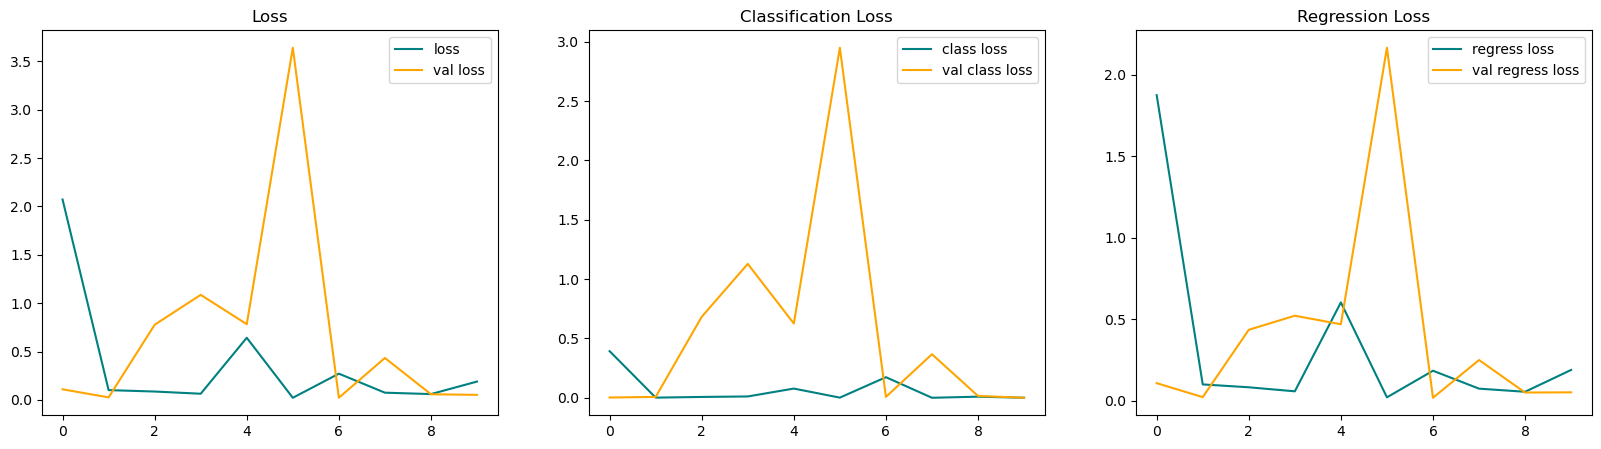

In [50]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

<h2>Make Predictions</h2>

<h4>11.1 Make Predictions on Test Set</h4>

In [51]:
test_data = test.as_numpy_iterator()

In [52]:
test_sample = test_data.next()

In [53]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 205ms/step


In [55]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4): 
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
#                             (255,0,0), 2)
    
#     ax[idx].imshow(sample_image)

<h4>11.2 Save the Model</h4>

In [56]:
from tensorflow.keras.models import load_model

In [57]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()